In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Y.Z.
"""
import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
# Personally built packages
# data_load_01 and data_load_01 are the two packages used to load the original data.
import data_load_01, data_load_02
# import m_ecr_state

In [2]:
# Predefined functions
#---------------------------------------------------------------------------------------------------------#
# Function to create charging and driving dataframes with designated features
#---------------------------------------------------------------------------------------------------------#
# The input includes real-world EV operating data and vehicle information.
# Vehicle model can be selected as specific requirements.
# A vehicle model can be specifically modified accorading to study requirements.
# The output is the dataframe with charging or driving features.
#---------------------------------------------------------------------------------------------------------#
def get_drv_chg_tbl(veh_model_tmp):
    # Loading dynamic vehicular operating data
    data_op = data_load_01.get_operating_data_auto()
    data_info = data_load_02.get_veh_info() # data specification data
    # merge dynamic and static data
    data_op_p1 = pd.merge(data_op, data_info, 
                          left_on='b.vin', right_on='vin') 
    data_op_p2 = data_op_p1.copy() #copy
    # Data screening of vehicle models
    msk =  data_op_p2.veh_model == veh_model_tmp 
    data_op_p3 = data_op_p2.loc[msk, :]
    data_op_p4 = data_op_p3.copy() #copy
    # To obtain the driving distances of individual sesssions.
    data_op_p4['dert_dist'] = (data_op_p4['b.stop_mileage'] - data_op_p4['b.start_mileage'])
    data_op_p4['dert_soc'] = data_op_p4['b.start_soc'] - data_op_p4['b.end_soc']
    data_op_p4['start_time'] = pd.to_datetime(data_op_p4['b.st_time_e'],unit='ms') + pd.DateOffset(hours=8)#unix time
    data_op_p4['end_time'] = pd.to_datetime(data_op_p4['b.et_time_e'],unit='ms')+ pd.DateOffset(hours=8)
    msk1 = data_op_p4['b.start_temp'] > -20
    data_op_p4 = data_op_p4.loc[msk1, :]
    # Get individual charging and driving datasets.
    msk1 = data_op_p4['start_time'].dt.year == 2019
    msk2 = data_op_p4['b.category'] == 10 # 10 and 30 for driving and charging sessions.
    msk3 = data_op_p4['b.category'] == 30 # 10 and 30 for driving and charging sessions.
    # Make a selection.
    data_op_p4_drv = data_op_p4[msk1 & msk2]        
    data_op_p4_chg = data_op_p4[msk1 & msk3]
    data_op_p4_drv['dert_soc'] = data_op_p4_drv['b.start_soc'] -  data_op_p4_drv['b.end_soc']
    # Name features.
    chg_cols = ['vin', 'veh_model', 'start_time', 'end_time','b.start_soc', 'b.end_soc', 'dert_soc', 
                'b.start_mileage', 'b.stop_mileage', 'b.power', 'b.volume', 'b.charge_c', 'b.start_temp', 
                'b.end_temp', 'city', 'fleet_type', ]
    drv_cols = ['vin', 'veh_model', 'start_time', 'end_time',
                'b.start_soc', 'b.end_soc', 'dert_soc',
                'b.start_mileage', 'b.stop_mileage', 'dert_dist',
                'b.start_temp', 'b.end_temp', 'city', 'fleet_type',]
    data_op_p5_chg = data_op_p4_chg[chg_cols]
    data_op_p5_drv = data_op_p4_drv[drv_cols]
    del msk1, msk2, msk3, chg_cols, drv_cols
    return data_op_p5_chg, data_op_p5_drv

#---------------------------------------------------------------------------------------------------------#
# Function to calculate energy consumption rates.
#---------------------------------------------------------------------------------------------------------#
# Calculate the consumed electricity.
# Compute the driving distances.
# Build new features used for energy consumption calculation.
# Obtain the energy consumption rates.
# The input is the output dataframe from function get_drv_chg_tbl.
# The output is a dataframe with the ECR feature and relevant operating information.
#---------------------------------------------------------------------------------------------------------#
def get_ecr_func_01(data_op_p5_drv, data_op_p5_chg, vin_list):
    data_op_p7_drv = pd.DataFrame()
    for vin_tmp in vin_list:
        # Separate individual vehicles by using key 'vin'.
        msk1 = data_op_p5_chg.vin == vin_tmp
        msk2 = data_op_p5_drv.vin == vin_tmp
        # Sort start time and reset indices.
        data_op_p6_chg = data_op_p5_chg[msk1].sort_values('start_time').reset_index(drop=True)
        data_op_p6_drv = data_op_p5_drv[msk2].sort_values('start_time').reset_index(drop=True)
        # Calculate the energy consumption rate.
        data_op_p6_drv['ecr'] = -1
        data_op_p6_drv['e_per_soc'] = -1
        data_op_p6_drv2 = pd.DataFrame(columns=data_op_p6_drv.columns)
        for i in range(len(data_op_p6_drv)):
            if i == 0:
                row_last = data_op_p6_drv.iloc[0, :]
            else:
                row = data_op_p6_drv.iloc[i, :]
                if (row['b.start_mileage'] == row_last['b.stop_mileage']) & \
                    (row['b.start_soc'] == row_last['b.end_soc']):
                    row_last['b.stop_mileage'] = row['b.stop_mileage']
                    row_last['dert_dist'] = (row_last['b.stop_mileage'] - row_last['b.start_mileage'])
                    row_last['end_time'] = row['end_time']
                    row_last['b.end_soc'] = row['b.end_soc']
                    row_last['dert_soc'] = row_last['b.start_soc'] - row_last['b.end_soc']
                    row_last['b.end_temp'] = row['b.end_temp']
                else:
                    data_op_p6_drv2 = pd.concat([data_op_p6_drv2, pd.DataFrame(row_last).T])
                    row_last = data_op_p6_drv.iloc[i, :]
        # data_op_p6_drv2
        for i in range(len(data_op_p6_drv2)-1):
            # Select driving sessions occuring between two charging sessions.
            t1 = data_op_p6_drv2.start_time.iloc[i] - pd.DateOffset(days=1)
            t2 = data_op_p6_drv2.start_time.iloc[i] + pd.DateOffset(days=1)
            msk1 = (data_op_p6_chg.start_time >= t1) & (data_op_p6_chg.start_time <= t2)
            data_block = data_op_p6_chg.loc[msk1, :]
            if len(data_block) == 0:
                continue
            e_per_soc_se = data_block['b.power']/ (-1 * data_block.dert_soc)
            e_per_soc = e_per_soc_se.mean()
            e_tmp = (e_per_soc * data_op_p6_drv2['dert_soc'].iloc[i])
            d_tmp = data_op_p6_drv2['dert_dist'].iloc[i]
            data_op_p6_drv2['ecr'].iloc[i] = e_tmp / d_tmp
            data_op_p6_drv2['e_per_soc'].iloc[i] = e_per_soc
        data_op_p7_drv = pd.concat([data_op_p7_drv, data_op_p6_drv2])
    data_op_p7_drv['dist_per_soc'] = data_op_p7_drv['dert_dist'] / data_op_p7_drv['dert_soc']
    return data_op_p7_drv

#---------------------------------------------------------------------------------------------------------#
# Function to generate ECR data from real-world EV operating data.
#---------------------------------------------------------------------------------------------------------#
# The input is the real-world vehicle data.
# The output is vehicle ECR data and relevant operating information.
#---------------------------------------------------------------------------------------------------------#
def get_data_ecr(veh_model_tmp='1a5afe0eb2520bdfa00134b987268a8b'):# vehicle models can be selected.
    dict_fleet = {'私人乘用车':'private', '公务乘用车':'official', 
                  '出租乘用车':'taix', '租赁乘用车':'rental'}
    dict_reg = {'上海市':'Shanghai', '北京市':'Beijing', '广州市':'Guangzhou'}
    print('Getting chg and drv tbls...\n')
    data_op_p5_chg, data_op_p5_drv = get_drv_chg_tbl(veh_model_tmp)
    vin_list = data_op_p5_chg.vin.unique()
    print('Computing ECRs...\n')
    data_op_p7_drv = get_ecr_func_01(data_op_p5_drv, data_op_p5_chg, vin_list)
    msk1 = data_op_p7_drv.ecr > 0.1
    msk2 = data_op_p7_drv.ecr < 0.5
    data_op_p8_drv = data_op_p7_drv.loc[msk1 & msk2, :]
    data_op_p8_drv['region'] = data_op_p8_drv['city'].apply(lambda x: dict_reg[x])
    data_op_p8_drv['fleet_type'] = data_op_p8_drv['fleet_type'].apply(lambda x: dict_fleet[x])
    del data_op_p8_drv['city']
    print('Finish.\n')
    return data_op_p8_drv

#---------------------------------------------------------------------------------------------------------#
# Class to build the fast polynominal fitting model by using numpy.
#---------------------------------------------------------------------------------------------------------#
# When training, the input is vector x, vector y, and the degree of the polynominal model, \
# and the output includes the parameters and the fitted model.
# When testing, the input is the vector x to be predicted, and the output is predicted vector y.
#---------------------------------------------------------------------------------------------------------#
class model_fit_poly_1d(object):
    def __init__(self,deg):
        self.f_ = None
        self.p_ = None
        self.deg = deg
    def fit(self,x,y):
        self.f_ = np.polyfit(x,y,self.deg)
        self.p_ = np.poly1d(self.f_)
    def predict(self,x_pre):
        poly_fit = self.p_(x_pre)
        return poly_fit
    def para(self):
        return self.f_

#---------------------------------------------------------------------------------------------------------#
# Multi-level outlier detection and filtering.
#---------------------------------------------------------------------------------------------------------#
# A function to detect and label the outliers of x and y series.
# The multi-level screening strategy is used in this part.
#---------------------------------------------------------------------------------------------------------#
def multilevel_filter(bins_num = 10,x_se_label = None,y_se_label= None,df=None):
    df_temp = df.copy()
    df_temp['filter'] = 0
    bins_cat = pd.cut(df_temp[x_se_label],bins=bins_num,labels=False)
    for i in range(bins_num):
        'filter 1'
        filter_1 = (bins_cat==i)
        se = df_temp.loc[filter_1,y_se_label]
        c1 = se.mean()
        std1 = se.std()
        'filter 2'
        filter_2 = (abs(df_temp[y_se_label]-c1)<=1*std1)
        se2 = df_temp.loc[filter_1 & filter_2,y_se_label]
        c2 = se2.mean()
        std2 = se2.std()        
        'filter 3'
        filter_3 = (abs(df_temp[y_se_label]-c2)<=3*std2)
        df_temp.loc[filter_1 & filter_3,'filter'] = 1
    return (df_temp['filter'] == 1)

#---------------------------------------------------------------------------------------------------------#
# Function to reclassify fleet types
#---------------------------------------------------------------------------------------------------------#
def fleet_class(cell): # classify fleet type into pri/pub
    if cell == 'private':
        return 'pr'
    elif cell in ['taix', 'rental']:
        return 'pu'
    else: # official
        return cell

#---------------------------------------------------------------------------------------------------------#
# Function to calculate the cumulative distribution, which is used to \
# calculate the cdf of daily driving distances.
# The input is a series of driving distances.
# The output is a distribution (x, y), and the fitting function f.
#---------------------------------------------------------------------------------------------------------#
def cdf_se(se): # cumulative distribution func
    x = np.linspace(0,10000,1000) 
    length = len(se)
    y = [len(se[se<=x_values])/length for x_values in tqdm(x)]
    y_np = np.array(y)
    para = np.polyfit(x,y_np,deg = 10)
    f = np.poly1d(para)
    return x,y,f

#---------------------------------------------------------------------------------------------------------#
# Function to get the energy consumption of EV groups.
# EVs in different cities are calculated separately and combined as an EC list.
#---------------------------------------------------------------------------------------------------------#
def ec_city(reg, p_public, ev_num_list): # energy cons. of groups in regions
    x = np.linspace(0,10000,1000)
    p_private = 1 - p_public
    if reg == 'BJ':
        f1 = mon_avg_dict['BJpr'][3]
        f2 = mon_avg_dict['BJpu'][3]
    elif reg == 'SH':
        f1 = mon_avg_dict['SHpr'][3]
        f2 = mon_avg_dict['SHpu'][3]
    elif reg == 'GZ':
        f1 = mon_avg_dict['GZpr'][3]
        f2 = mon_avg_dict['GZpu'][3]
    y_ei_list = []
    for ev_num in ev_num_list:
        y_ei = 0
        for i in range(len(x)-1):
            # F1 - F1' = f * du. cdf -> pdf. A diff process is needed.
            fi1 = f1(x[i+1]) - f1(x[i])
            fi2 = f2(x[i+1]) - f2(x[i])
            E = p_private * fi1 + p_public * fi2
            xtmp = (x[i] + x[i+1]) / 2
            y_ei = y_ei + (ev_num * E) * (xtmp * k)
        y_ei_list.append(y_ei)
    return y_ei_list

#---------------------------------------------------------------------------------------------------------#
# Function to calculate the average of energy consumption of EVs in different regions.
# Three regions are targetted in this section, including Beijing, Shanghai, and Guangzhou.
#---------------------------------------------------------------------------------------------------------#
def ec_region_avg(reg, p_public, ev_num_list):
    p_private = 1 - p_public
    if reg == 'BJ':
        m1 = mon_avg_dict['BJpr'][0]
        m2 = mon_avg_dict['BJpu'][0]
    elif reg == 'SH':
        m1 = mon_avg_dict['SHpr'][0]
        m2 = mon_avg_dict['SHpu'][0]
    elif reg == 'GZ':
        m1 = mon_avg_dict['GZpr'][0]
        m2 = mon_avg_dict['GZpu'][0]
    y_ei_list = []
    for ev_num in ev_num_list:
        y = ev_num * k * (p_private * m1 + p_public * m2)
        y_ei_list.append(y)
    return y_ei_list

In [3]:
    #---------------------------------------------------------------------------------------------------------#   
    # Load dynamic EV operating data and vehicle specification data.
    # Connect the information from two data sources.
    # Create a new dataframe object.
    #---------------------------------------------------------------------------------------------------------#
    data_op_p8_drv = get_data_ecr()
    data_op_p8_drv['b.start_temp'] = data_op_p8_drv['b.start_temp'].astype(float)
    data_op_p8_drv['ecr'] = data_op_p8_drv['ecr'].astype(float)
    msk_bin = multilevel_filter(x_se_label='b.start_temp',y_se_label='ecr', df=data_op_p8_drv)
    data_op_p9_drv = data_op_p8_drv.loc[msk_bin, :]

Getting chg and drv tbls...

Computing ECRs...

Finish.



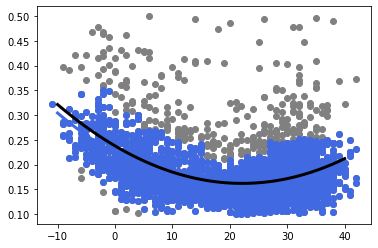

In [4]:
    #---------------------------------------------------------------------------------------------------------#
    # Function to calculate the average of energy consumption rates.
    #---------------------------------------------------------------------------------------------------------#
    def get_avg_ecr(mon, reg='Beijing', data_op_p9_drv=data_op_p9_drv):
        msk1 = data_op_p9_drv.region == reg
        msk2 = data_op_p9_drv.start_time.dt.month == mon
        msk = msk1 & msk2
        return data_op_p9_drv.loc[msk, 'ecr'].mean()
        
    #---------------------------------------------------------------------------------------------------------#
    # Extract average ECR functions at varied temperatures.
    # Compare the data before and after multi-level processing.
    #---------------------------------------------------------------------------------------------------------#
    # fitting p8
    x_temp = np.linspace(-10, 40, 100)
    model_01 = model_fit_poly_1d(3)
    model_01.fit(data_op_p8_drv['b.start_temp'], data_op_p8_drv['ecr'])
    # fitting p9
    model_02 = model_fit_poly_1d(3)
    model_02.fit(data_op_p9_drv['b.start_temp'], data_op_p9_drv['ecr'])
    # plot
    plt.scatter(data_op_p8_drv['b.start_temp'], data_op_p8_drv['ecr'], c='gray')
    plt.scatter(data_op_p9_drv['b.start_temp'], data_op_p9_drv['ecr'], c='royalblue')
    plt.plot(x_temp, model_01.predict(x_temp), 'k', linewidth=3)
    plt.plot(x_temp, model_02.predict(x_temp), 'royalblue', linewidth=3)
    plt.show()
    del x_temp

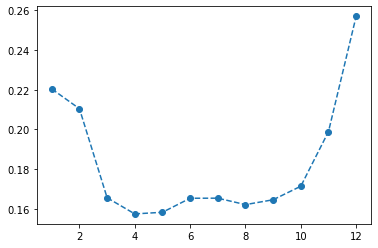

In [5]:
    #---------------------------------------------------------------------------------------------------------#
    # Calculate the changes of EV ECRs during different months.
    # The input includes regional temperature data and ecr models.
    # The output is the average ECR states of EVs.
    #---------------------------------------------------------------------------------------------------------#
    # Loading regional temperature data.
    data_city_temp = data_load_02.get_ambient_temp()
    msk1 = data_city_temp.Region == 'Beijing'
    msk2 = data_city_temp.Item == 'Avg'
    msk3 = data_city_temp.Item == 'Max'
    msk4 = data_city_temp.Item == 'Min'
    data_city_temp_p1 = data_city_temp.loc[msk1 & msk2, 'January':'December']
    data_city_temp_p2 = data_city_temp.loc[msk1 & msk3, 'January':'December']
    data_city_temp_p3 = data_city_temp.loc[msk1 & msk4, 'January':'December']
    months = data_city_temp_p1.columns
    # months = [m[0:3]+'.' for m in months]
    months = [str(int(s)) for s in range(1, 13, 1)]
    temps_avg = data_city_temp_p1.values.reshape(-1)
    temps_max = data_city_temp_p2.values.reshape(-1)
    temps_min = data_city_temp_p3.values.reshape(-1)
    del msk1, msk2, msk3, msk4, data_city_temp_p1, \
        data_city_temp_p2, data_city_temp_p3
    # ecr stat.
    mon_tmp = np.arange(1, 13, 1)
    mon_ecr_list = list(map(get_avg_ecr, mon_tmp))
    plt.plot(mon_tmp, mon_ecr_list, '--o')
    del mon_tmp, mon_ecr_list

In [6]:
    #---------------------------------------------------------------------------------------------------------#
    # Averge and worst case calculations for ECRs.
    # Regional temperature dataframe and EV ECR states are the input.
    # ECRs in different scenarios are calculated.
    #---------------------------------------------------------------------------------------------------------#
    # Temperature data processing.
    region_temp2 = data_city_temp.T
    region_bu = region_temp2.loc['January':, :].applymap(model_02.predict)
    region_bu = pd.concat([region_temp2.loc[['Region','Item'],:], region_bu])
    region_plot = pd.DataFrame()
    regions = data_city_temp.Region.unique()
    # For varied regions.
    for region in regions:
        maskcol1 = (region_bu.loc['Region', :]==region)
        maskcol2 = (region_bu.loc['Item', :]=='Avg')
        temp = region_bu.loc[:, maskcol1]
        max_col = temp.loc['January':'December', :].astype(float).max().idxmax()
        max_month = temp.loc['January':'December', max_col].astype(float).idxmax()
        max_value = temp.loc[max_month, max_col]
        avg_value = temp.loc['January':'December', temp.loc['Item',:]=='Avg'].mean()
        dftemp = pd.DataFrame({'Region':region, 'Avg': avg_value,'max':max_value, 'max month': max_month})
        region_plot = pd.concat([region_plot, dftemp])
    del maskcol1, maskcol2, max_col, temp, dftemp, avg_value, max_value, max_month
    
    #---------------------------------------------------------------------------------------------------------#
    # Relative difference calculations
    # Month-to-month differences of ECRs are obtained.
    # Growth rates of ECRs in varied regions.
    # Temperature data processing.
    #---------------------------------------------------------------------------------------------------------#
    region_temp = data_city_temp.set_index(['Region', 'Item'])
    ecr_temp = region_temp.loc['Beijing', :].applymap(model_02.predict) # model_01
    y = ecr_temp.loc['Avg'].copy()
    min_ldev = model_02.predict(22)
    # Diffs of values between consecutive months.
    ydf = y.diff(1)
    ydf.iloc[0] = y['January'] - model_02.predict(-2.1) # 201812 temperature: -2.1
    ysft = y.shift(1)
    ysft.iloc[0] = model_02.predict(-2.1)
    # Relative rates
    yr = (y - min_ldev)/min_ldev
    yrdf = yr.diff(1)
    yrdf.iloc[0] = yr['January'] - (model_02.predict(-2.1) - min_ldev)/min_ldev
    yrsft = yr.shift(1)
    yrsft.iloc[0] = (model_02.predict(-2.1) - min_ldev)/min_ldev
    yrdf1 = yrdf.copy()
    yrdf1[yrdf1<0] = 0
    yrdf2 = yrdf.copy()
    yrdf2[yrdf2>=0] = 0

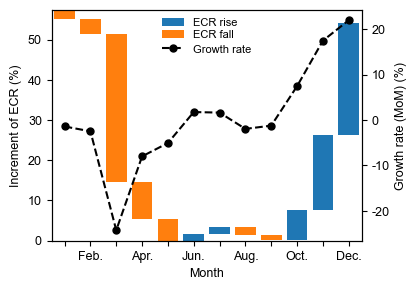

In [7]:
    #---------------------------------------------------------------------------------------------------------#
    # ECR diffs in varied months.
    #---------------------------------------------------------------------------------------------------------#
    Month = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.','Dec.']
    Month2 = ['', 'Feb.', '', 'Apr.', '', 'Jun.','',  'Aug.', '', 'Oct.', '','Dec.']
    Month_se = pd.Series(Month)
    plt.style.use('default')
    plt.rcParams['font.family'] = 'Arial'
    f_size = 10
    font = {'size': f_size-1}
    font2 = {'size': f_size-1}
    # Initiate the figure.
    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(111)
    # Draw the diff bars with bottoms on previous ones.
    ax.bar(Month_se, yrdf1, bottom=yrsft, label='ECR rise', edgecolor='black', linewidth=0)#color='r', 
    ax.bar(Month_se, yrdf2, bottom=yrsft, label='ECR fall', edgecolor='black', linewidth=0)#color='b', 
    # ax2 plot
    ax2 = ax.twinx()
    ax2.plot(Month, ydf/ysft,'--o',color='k', label='Growth rate',ms=5, linewidth=1.5)
    # Set up the configuration for ax.
    ax.set_xticklabels(Month)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(100*x) for x in vals])
    ax.set_xbound(-0.5,11.5)
    ax.set_xlabel("Month", font)
    ax.set_ylabel("Increment of ECR (%)", font)
    ax.tick_params(labelsize=f_size-1)
    ax.set_xticklabels(Month2)
    # Set up the configuration for ax2.
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.0f}'.format(100*x) for x in vals])
    ax2.set_ylabel("Growth rate (MoM) (%)", font)
    ax2.tick_params(labelsize=f_size-1)
    ax.legend(fontsize=f_size-2,loc=(0.34, 0.85),ncol=1,frameon=False,
               columnspacing=0.6,labelspacing=0.2,borderaxespad=0.1)
    ax2.legend(fontsize=f_size-2,loc=(0.34, 0.788),ncol=1,frameon=False,
                columnspacing=0.6,labelspacing=0.2,borderaxespad=0.1)
    del y, ydf, ysft, yr, yrdf, yrsft, yrdf1, yrdf2

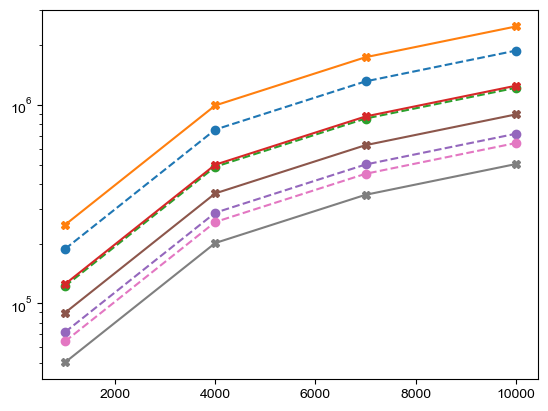

In [8]:
    #---------------------------------------------------------------------------------------------------------#
    # Calculate the changes of energy consumption with the prospects of EV scaling up.
    # Four regions including Beijing, New York City, Shanghai, and London are targetted.
    # Three variables are used: ECR changes, development levels, group scale.
    #---------------------------------------------------------------------------------------------------------#
    _regions = [ 'Beijing', 'New York', 'Shanghai','London']
    # The temperature data of months before the first line.
    # They are used to compute the diffs of the first line and obtained by temperature data sources.
    d1812 = {'Beijing': -2.1, 'Shanghai':8.6, 'Guangzhou':16.9, 'New York':-2.6, 
             'Los Angeles':14.9, 'London':9, 'Paris':6.3, 'Berlin':4.7, 'Tokyo':8.6}
    monthly_d_list = [500, 1500, 2500, 3500, 4500, 5500]
    monthly_d = monthly_d_list[4]
    ax = plt.figure().add_subplot(111)
    for i in range(len(_regions)):
        ecr_temp = region_temp.loc[_regions[i], :].applymap(model_02.predict)
        y = ecr_temp.loc['Avg'].copy()
        t1812 = d1812[_regions[i]]# 201812 temperature: -2.1
        ydf = y.diff(1)
        ydf.iloc[0] = y['January'] - model_02.predict(t1812)
        # Calculate the maximum and minimum values.
        max_df = ydf.max()
        max_df_mon = ydf.idxmax()
        neg_df = ydf.min()
        neg_df_mon = ydf.idxmin()
        ev_num = np.linspace(1000, 10000, 4)
        y = monthly_d * max_df  * ev_num
        y2 = monthly_d * neg_df* ev_num
        # Plot curves
        ax.plot(ev_num, y, '--o', label = _regions[i]+' (rise)')
        ax.plot(ev_num, -y2, '-X',label = _regions[i]+' (fall)')
        ax.set_yscale('log')
    del max_df, y, y2, ydf, max_df_mon, ev_num, t1812, d1812, \
    monthly_d, monthly_d_list, _regions, neg_df, neg_df_mon

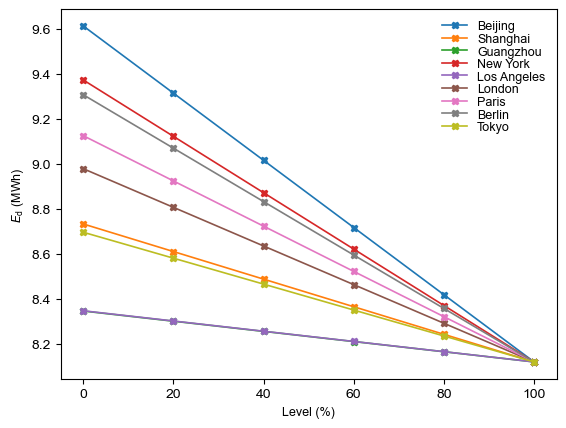

In [9]:
    #---------------------------------------------------------------------------------------------------------#
    # Calculate the annual energy consumption of EVs in 9 regions with varying development levels.
    #---------------------------------------------------------------------------------------------------------#
    # Cumulative consumption
    mile_per_month1 = 4500
    x = np.linspace(0, 1, 6)
    ev_num=1
    regions= data_city_temp.Region.unique()
    ax = plt.figure().add_subplot(111)
    for region in regions:
        ecr_temp_win = region_temp.loc[region, ['January', 'February', 'December']].applymap(model_02.predict)
        ecr_temp = region_temp.loc[region, :].applymap(model_02.predict)
        k = ecr_temp.loc['Avg'].sum()  # ecr average sum 12 month
        k_mean = ecr_temp_win.loc['Avg'].mean()  # ecr average sum 12 month
        k0 = 12 * min_ldev
        ki = k - k0
        y = ev_num * mile_per_month1 * (k - ki * (x))
        ax.plot(x, y, '-', label=region, ms=4.5, marker='X', linewidth=1.2)
    # Configure the axis.
    ax.set_xlabel('Level (%)', font)
    ax.set_ylabel('$E_\mathregular{d}$ (MWh)', font)
    ax.set_yticklabels(ax.get_yticks()/1000)
    ax.legend(ncol=1, loc='upper right', fontsize=9, frameon=False, labelspacing=0.05)
    ax.set_xticklabels(['{:,.0f}'.format(100*x) for x in ax.get_xticks()])
    plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1483.08it/s]


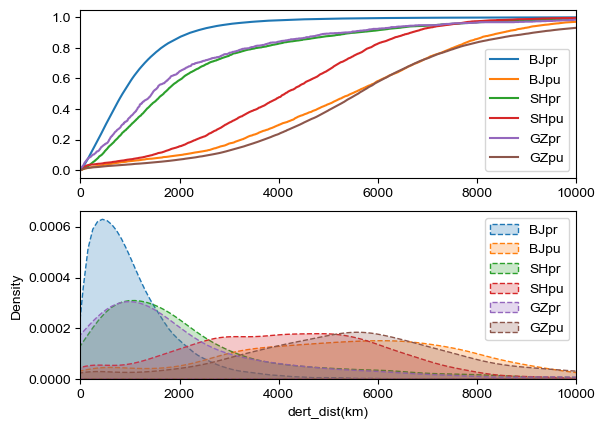

In [10]:
    #---------------------------------------------------------------------------------------------------------#
    # Monthly driving distances of EVs in varied regions and fleet types.
    # Calculate the distributions of EV monthly driving distances.
    # Process the cdf of monthly driving distributions.
    # Three regions including Beijing, Shanghai, and Guangzhou are targetted.
    # Two fleet types including private and public ones are targetted.
    #---------------------------------------------------------------------------------------------------------#
    # monthly distance data
    dict_mon_dict = data_load_02.get_monthly_dist()
    mon_avg_dict = {} # averages
    for reg in ['BJ', 'SH', 'GZ']:
        for ft in ['pr', 'pu']:
            s = '%s%s'%(reg, ft)
            m = dict_mon_dict[s].mean()
            x,y,f = cdf_se(dict_mon_dict[s])
            mon_avg_dict.update({s: [dict_mon_dict[s].mean(), x, y, f]})
    del reg, ft, s
    
    # monthly dist. distributions
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    for reg in ['BJ', 'SH', 'GZ']:
        for ft in ['pr', 'pu']:
            s = '%s%s'%(reg, ft)
            ax1.plot(mon_avg_dict[s][1], mon_avg_dict[s][2], label='%s%s'%(reg, ft))
            sns.distplot(dict_mon_dict[s], hist=False, #color='b',
                          kde_kws={"shade": True,'linewidth':1,'linestyle':'--'},
                          ax=ax2, label='%s%s'%(reg, ft)) # bins=bins,s
    ax1.set_xbound(0, 10000)
    ax2.set_xbound(0, 10000)
    ax1.legend()
    ax2.legend()
    del s, reg, ft

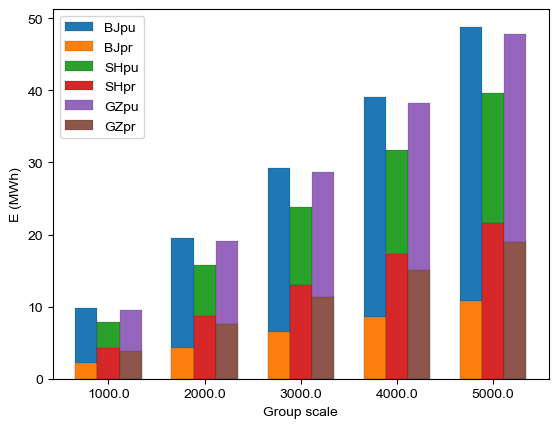

In [11]:
    #---------------------------------------------------------------------------------------------------------#
    # The annual energy consumption of EV groups
    # The ratio of public and private EVs ranges from 0 to 1 to denote different EV groups.
    # The group scale increases from 1000 to 5000.
    # Three regions are targetted including Beijing, Shanghai, and Guangzhou.
    #---------------------------------------------------------------------------------------------------------#
    # annual cons. of veh groups
    fig = plt.figure()
    wid, lw, ec = 0.23, 0.1, 'k'
    ax = fig.add_subplot(111)
    x = np.arange(5)
    ev_num = np.linspace(1000,5000,5)
    for reg, ktmp in zip(['BJ', 'SH', 'GZ'], [-1, 0, 1]):
        p_public = 1
        y = ec_city(reg, p_public, ev_num)
        ax.bar(x + ktmp * wid, np.array(y)/10**6, width=wid,
               label='%s%s'%(reg, 'pu'), linewidth=lw, edgecolor=ec)
        p_public = 0
        y = ec_city(reg, p_public, ev_num)
        ax.bar(x + ktmp * wid, np.array(y)/10**6, width=wid,
               label='%s%s'%(reg, 'pr'), linewidth=lw, edgecolor=ec)
    ax.set_xticklabels([(s+1) * 1000 for s in ax.get_xticks()])
    ax.set_ylabel('E (MWh)')
    ax.set_xlabel('Group scale')
    ax.legend()
    del p_public, reg, ktmp, wid, lw, ec